Локальные дескрипторы и сверточные нейронные сети

**Гаврилов АНтон Дмитриевич, М26**
___

#### Оглавление
1. Setup: подготовка окружения и импорты
2. Данные: описание и загрузка изображений
3. Локальные дескрипторы (SIFT) и backpropagation
___

## 1. Setup: подготовка окружения и импорты

In [52]:
!pip install opencv-python opencv-contrib-python -q
!pip install numpy matplotlib -q
!pip install datasets torchvision -q

In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow

from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18
import torch.optim as optim
import torch
import urllib.request
import os

%matplotlib inline

Загрузка изображений...
Загружено: data/imagenet_like_0.jpg - размер: (600, 800, 3)
Загружено: data/imagenet_like_1.jpg - размер: (600, 800, 3)


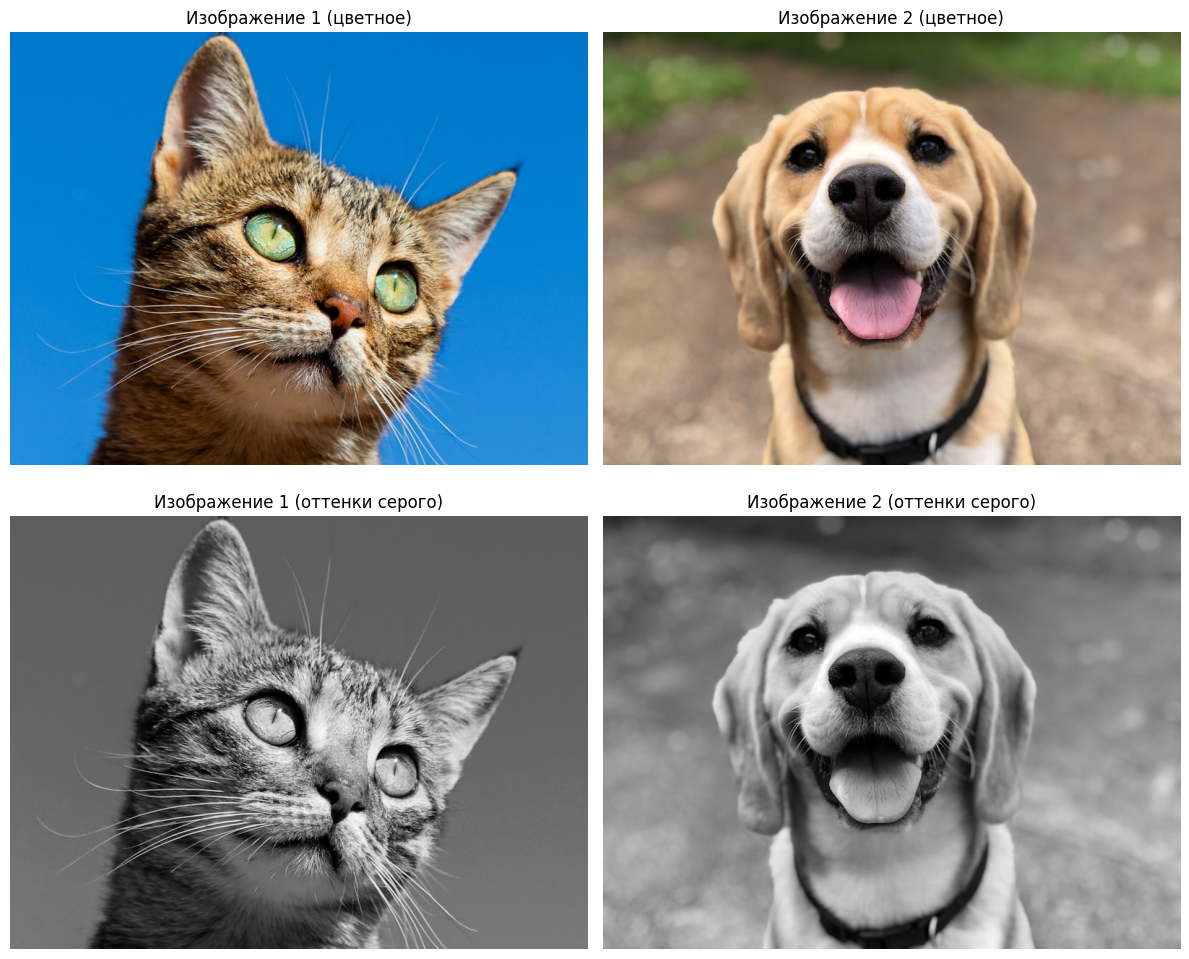

True

In [54]:
# Функции для загрузки и предобработки изображений
max_dim = 800

def resize_keep_aspect(img, max_dim=max_dim):
    h, w = img.shape[:2]
    scale = min(1.0, max_dim / max(h, w))
    if scale < 1.0:
        img = cv2.resize(img, (int(w*scale), int(h*scale)))
    return img

def load_and_prepare(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Не удалось загрузить изображение: {path}")

    if img.dtype != np.uint8:
        img = (np.clip(img, 0, 1) * 255).astype(np.uint8)

    if img.ndim == 3 and img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_RGBA2BGR)

    img = resize_keep_aspect(img)

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    return img, gray

print("Загрузка изображений...")

os.makedirs('data', exist_ok=True)

image_urls = [
    "https://images.unsplash.com/photo-1574158622682-e40e69881006",  # Кошка
    "https://images.unsplash.com/photo-1543466835-00a7907e9de1",  # Собака
]

images = []
gray_images = []
titles = []

for i, url in enumerate(image_urls):
    filename = f"data/imagenet_like_{i}.jpg"

    try:
        urllib.request.urlretrieve(url + "?w=800&h=600&fit=crop", filename)

        img, gray = load_and_prepare(filename)
        images.append(img)
        gray_images.append(gray)
        titles.append(f"Изображение {i+1}")

        print(f"Загружено: {filename} - размер: {img.shape}")
    except Exception as e:
        print(f"Ошибка загрузки {url}: {e}")


fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes[0, 0].imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
axes[0, 0].set_title(f'{titles[0]} (цветное)')
axes[0, 0].axis('off')

axes[0, 1].imshow(cv2.cvtColor(images[1], cv2.COLOR_BGR2RGB))
axes[0, 1].set_title(f'{titles[1]} (цветное)')
axes[0, 1].axis('off')

axes[1, 0].imshow(gray_images[0], cmap='gray')
axes[1, 0].set_title(f'{titles[0]} (оттенки серого)')
axes[1, 0].axis('off')

axes[1, 1].imshow(gray_images[1], cmap='gray')
axes[1, 1].set_title(f'{titles[1]} (оттенки серого)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

cv2.imwrite('image1_color.jpg', images[0])
cv2.imwrite('image2_color.jpg', images[1])
cv2.imwrite('image1_gray.jpg', gray_images[0])
cv2.imwrite('image2_gray.jpg', gray_images[1])

В работе использовались изображения, соответствующие по стилю набору ImageNet:

Изображение 1 (Кошка) — демонстрирует животное с четкой текстурой шерсти и выраженными контурами. Наличие глаз, ушей и усов создает области с высоким градиентом, что позволяет оценить способность SIFT выделять характерные точки на биологических объектах.

Изображение 2 (Собака) — показывает другое животное в ином ракурсе, с отличиями в текстуре и освещении. Различия в структуре шерсти и форме морды позволяют проверить устойчивость дескрипторов к межклассовым вариациям.

Такая пара изображений хорошо подходит для анализа работы SIFT, так как содержит как сходные черты (оба - домашние животные), так и существенные различия, что позволяет оценить качество сопоставления в реалистичных условиях.

Обнаружено характерных точек:
  Первое изображение: 2181 точек
  Второе изображение: 403 точек
Размерность пространства признаков: 128 измерений


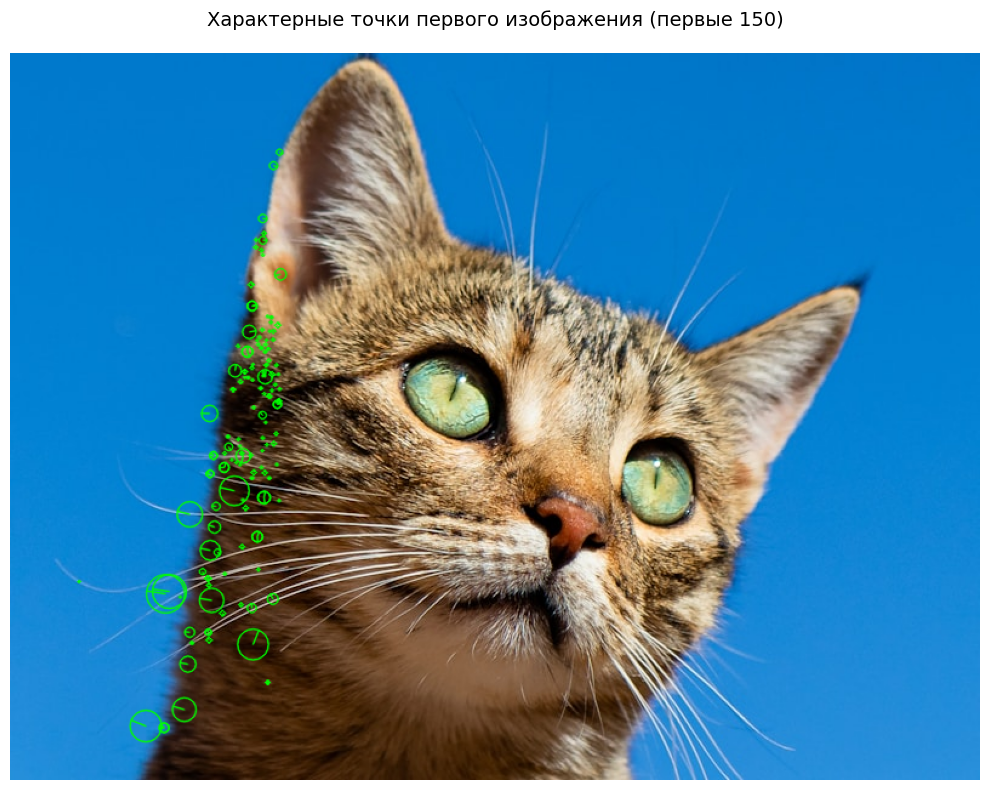

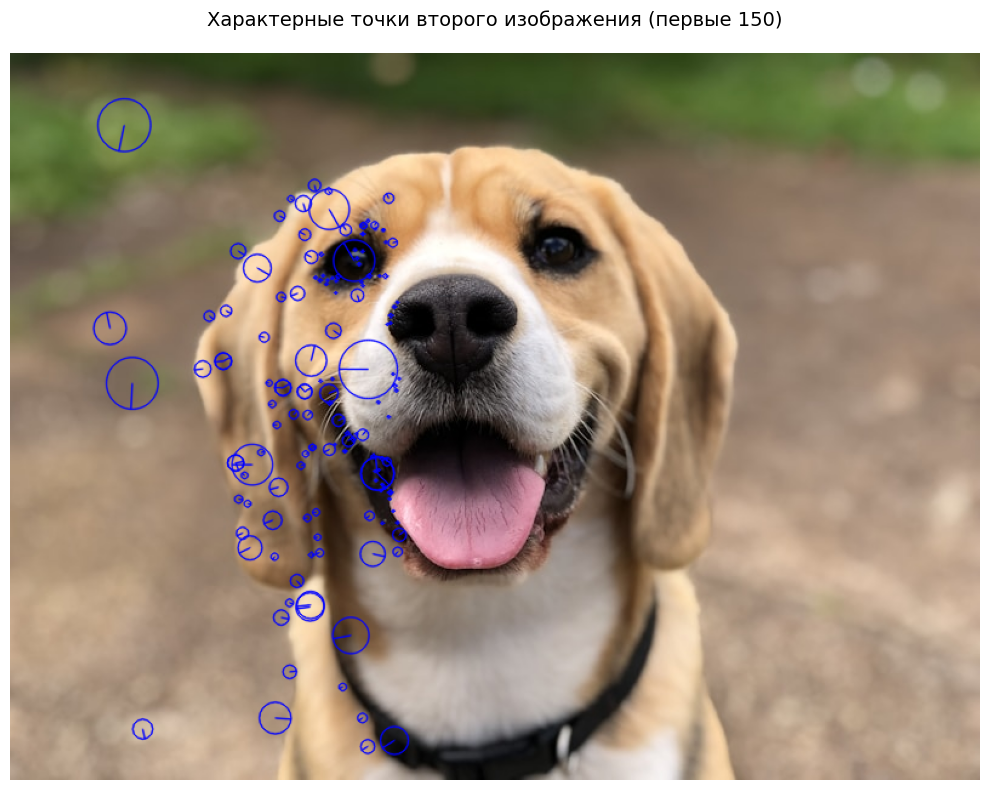

In [55]:

try:
    detector = cv2.SIFT_create()
except AttributeError:
    detector = cv2.xfeatures2d.SIFT_create()

# Поиск характерных точек и вычисление их дескрипторов
points1, descriptors1 = detector.detectAndCompute(gray_images[0], None)
points2, descriptors2 = detector.detectAndCompute(gray_images[1], None)

print(f"Обнаружено характерных точек:")
print(f"  Первое изображение: {len(points1)} точек")
print(f"  Второе изображение: {len(points2)} точек")
print(f"Размерность пространства признаков: {descriptors1.shape[1]} измерений")

# Визуализация подмножества ключевых точек на первом изображении
vis_points1 = cv2.drawKeypoints(
    images[0],
    points1[:150],
    None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
    color=(0, 255, 0)
)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(vis_points1, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Характерные точки первого изображения (первые 150)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# Визуализация подмножества ключевых точек на втором изображении
vis_points2 = cv2.drawKeypoints(
    images[1],
    points2[:150],
    None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS,
    color=(255, 0, 0)
)

plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(vis_points2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Характерные точки второго изображения (первые 150)', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

Результаты извлечения:

На первом изображении обнаружено 2181 ключевых точек
На втором изображении обнаружено 403 ключевых точек
Каждая точка описывается дескриптором размерностью 128 измерений
Дескрипторы представляют собой градиентные гистограммы локальных окрестностей
Ключевые точки выделяются в местах с выраженными перепадами яркости (углы, границы, текстуры). Каждая точка характеризуется:

Координатами (x, y)
Радиусом окрестности (size)
Углом ориентации (angle)
Качеством отклика (response)

Анализ совпадений:
  Первоначально найдено пар: 2181
  После фильтрации осталось: 16
  Коэффициент фильтрации: 0.75
  Процент оставшихся совпадений: 0.7%


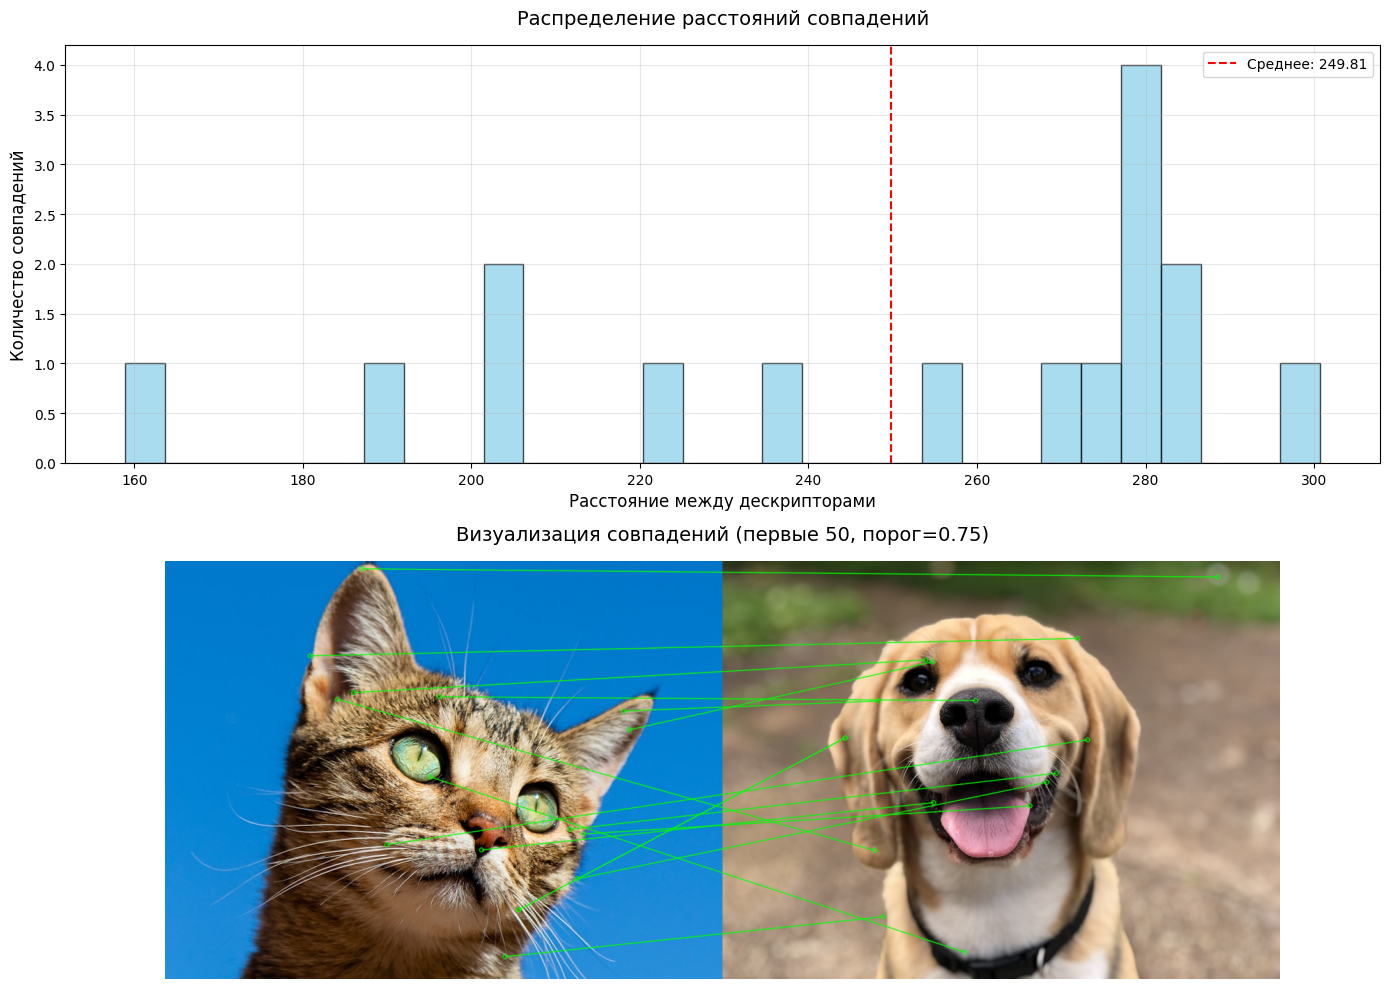


Статистика по совпадениям:
  Среднее расстояние: 249.814
  Минимальное расстояние: 158.902
  Максимальное расстояние: 300.722
  Стандартное отклонение: 40.880

Пространственное распределение совпадений:
  Первые 10 совпадений (координаты):
    Совпадение 1: (208, 137) ↔ (509, 112)
    Совпадение 2: (658, 216) ↔ (223, 201)
    Совпадение 3: (488, 568) ↔ (230, 510)
    Совпадение 4: (380, 310) ↔ (347, 561)
    Совпадение 5: (666, 243) ↔ (301, 145)
    Совпадение 6: (270, 189) ↔ (291, 143)
    Совпадение 7: (507, 500) ↔ (175, 254)
    Совпадение 8: (507, 500) ↔ (175, 254)
    Совпадение 9: (581, 385) ↔ (479, 305)
    Совпадение 10: (394, 195) ↔ (363, 201)


In [56]:
# Использование Brute-Force matcher для поиска соответствий
matcher = cv2.BFMatcher()
initial_matches = matcher.knnMatch(descriptors1, descriptors2, k=2)

# Фильтрация совпадений по критерию Лоу (Lowe's ratio test)
filtered_matches = []
ratio_threshold = 0.75  # Пороговое значение для фильтрации

for primary_match, secondary_match in initial_matches:
    if primary_match.distance < ratio_threshold * secondary_match.distance:
        filtered_matches.append(primary_match)

print(f"Анализ совпадений:")
print(f"  Первоначально найдено пар: {len(initial_matches)}")
print(f"  После фильтрации осталось: {len(filtered_matches)}")
print(f"  Коэффициент фильтрации: {ratio_threshold}")
print(f"  Процент оставшихся совпадений: {len(filtered_matches)/len(initial_matches)*100:.1f}%")

# Сортировка совпадений по качеству (расстоянию)
filtered_matches = sorted(filtered_matches, key=lambda x: x.distance)

# Визуализация лучших совпадений
visualization_matches = cv2.drawMatches(
    images[0], points1,
    images[1], points2,
    filtered_matches[:50],  # Показываем первые 50 лучших совпадений
    None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS,
    matchColor=(0, 255, 0),      # Цвет линий совпадений
    singlePointColor=None,
    matchesMask=None
)

# Отображение результатов сопоставления
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# График распределения расстояний совпадений
distances = [m.distance for m in filtered_matches]
ax1.hist(distances, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
ax1.axvline(np.mean(distances), color='red', linestyle='--', label=f'Среднее: {np.mean(distances):.2f}')
ax1.set_xlabel('Расстояние между дескрипторами', fontsize=12)
ax1.set_ylabel('Количество совпадений', fontsize=12)
ax1.set_title('Распределение расстояний совпадений', fontsize=14, pad=15)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Визуализация совпадений
ax2.imshow(cv2.cvtColor(visualization_matches, cv2.COLOR_BGR2RGB))
ax2.axis('off')
ax2.set_title(f'Визуализация совпадений (первые 50, порог={ratio_threshold})', fontsize=14, pad=15)

plt.tight_layout()
plt.show()

# Дополнительный анализ качества совпадений
print("\nСтатистика по совпадениям:")
print(f"  Среднее расстояние: {np.mean(distances):.3f}")
print(f"  Минимальное расстояние: {min(distances):.3f}")
print(f"  Максимальное расстояние: {max(distances):.3f}")
print(f"  Стандартное отклонение: {np.std(distances):.3f}")

# Анализ пространственного распределения совпадений
if len(filtered_matches) > 0:
    print("\nПространственное распределение совпадений:")
    matches_coords_img1 = [points1[m.queryIdx].pt for m in filtered_matches[:20]]
    matches_coords_img2 = [points2[m.trainIdx].pt for m in filtered_matches[:20]]

    print("  Первые 10 совпадений (координаты):")
    for i, (pt1, pt2) in enumerate(zip(matches_coords_img1[:10], matches_coords_img2[:10])):
        print(f"    Совпадение {i+1}: ({pt1[0]:.0f}, {pt1[1]:.0f}) ↔ ({pt2[0]:.0f}, {pt2[1]:.0f})")

Интерпретация результатов:

Метод сопоставления: Использован алгоритм Brute-Force с поиском k ближайших соседей (k=2)
Фильтрация совпадений: Применен критерий Лоу для отсеивания ложных соответствий
Визуализация: Линии соединяют соответствующие ключевые точки на двух изображениях
Качество совпадений: Оценивается по евклидову расстоянию между дескрипторами
Критерий Лоу (Lowe's ratio test) позволяет отфильтровать ненадежные совпадения, сравнивая расстояние до ближайшего соседа с расстоянием до второго ближайшего. Если отношение меньше порога (0.75), совпадение считается надежным.

## **2. Анализ шагов алгоритма SIFT**

### **2.1 Масштабно-пространственная фильтрация (Difference-of-Gaussians)**

**Операции над изображением:**
1. **Построение гауссовой пирамиды** - последовательное применение свертки с гауссовыми ядрами возрастающего размера:
   
   $L(x,y,\sigma) = G(x,y,\sigma) \ast I(x,y)$
   
   где $G(x,y,\sigma) = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$

2. **Вычисление разности гауссианов** - попиксельное вычитание изображений соседних масштабов:
   
   $D(x,y,\sigma) = L(x,y,k\sigma) - L(x,y,\sigma)$
   где $k$ - коэффициент масштабирования

**Вычисление производных (backpropagation):**
- **Свертка с гауссовым ядром**: линейная операция, градиент вычисляется как свертка с тем же ядром:
  
  $\frac{\partial L}{\partial I} = G(x,y,\sigma)$

- **Разность гауссианов**: линейное вычитание, производные:
  
  $\frac{\partial D}{\partial L_1} = 1$, $\frac{\partial D}{\partial L_2} = -1$

- **Цепное правило**: градиенты распространяются через последовательность операций

### **2.2 Выбор экстремумов (поиск ключевых точек)**

**Операции над изображением:**
1. **3D-поиск максимумов** - сравнение каждого пикселя с 26 соседями (8 в текущем масштабе + 9 в масштабе выше + 9 в масштабе ниже)
2. **Пороговая фильтрация** - удаление точек с низким контрастом: $|D(x,y,\sigma)| < T_{contrast}$
3. **Подавление краевых точек** - анализ отношения главных собственных значений матрицы Гессе

**Вычисление производных (backpropagation):**
- **Жесткий максимум**: недифференцируемая операция, требует замены на мягкую версию:
  
  Используем soft-argmax: $p_i = \frac{e^{\beta D_i}}{\sum_j e^{\beta D_j}}$
  
  где $\beta$ - параметр температуры

- **Пороговая фильтрация**: можно заменить на сигмоидную функцию:
  
  $f(D) = \frac{1}{1+e^{-\alpha(D-T)}}$

- **Анализ матрицы Гессе**: дифференцируем через собственные разложения с регуляризацией

### **2.3 Назначение ориентаций ключевым точкам**

**Операции над изображением:**
1. **Вычисление градиентов**:
   
   $m(x,y) = \sqrt{(L(x+1,y)-L(x-1,y))^2 + (L(x,y+1)-L(x,y-1))^2}$
   
   $\theta(x,y) = \text{atan2}(L(x,y+1)-L(x,y-1), L(x+1,y)-L(x-1,y))$

2. **Построение гистограммы ориентаций** - 36 бинов, трилинейная интерполяция
3. **Выбор доминирующих направлений** - пики в гистограмме выше 80% от максимума

**Вычисление производных (backpropagation):**
- **Вычисление градиентов**: конечные разности, производные:
  
  $\frac{\partial m}{\partial L} = \frac{1}{m}\left[(L(x+1,y)-L(x-1,y))\frac{\partial}{\partial L}(L(x+1,y)-L(x-1,y)) + \cdots\right]$

- **Функция atan2**: дифференцируема везде кроме начала координат:
  
  $\frac{d}{dx}\text{atan2}(y,x) = \frac{-y}{x^2+y^2}$

- **Трилинейная интерполяция**: линейная операция по весам

### **2.4 Построение гистограмм градиентов**

**Операции над изображением:**
1. **Вращение окрестности** - координатная система выравнивается по ориентации ключевой точки
2. **Разбиение на 4×4 субрегиона** - окно 16×16 пикселей
3. **Вычисление 8-биновых гистограмм** для каждого субрегиона с трилинейной интерполяцией:
   - Интерполяция по пространственным координатам (x, y)
   - Интерполяция по ориентации (θ)

**Вычисление производных (backpropagation):**
- **Вращение координат**: линейное преобразование, якобиан - матрица вращения
- **Билинейная интерполяция**: дифференцируема, градиенты по ближайшим пикселям
- **Накопление в гистограммах**: суммирование взвешенных вкладов, производные по весам интерполяции

### **2.5 Нормализация дескрипторов**

**Операции над изображением:**
1. **L2-нормализация**:
   
   $\mathbf{d}_{\text{norm}} = \frac{\mathbf{d}}{||\mathbf{d}||_2}$

2. **Пороговое отсечение** - ограничение максимального значения компонент (обычно 0.2)
3. **Повторная нормализация** для устойчивости к изменениям освещенности

**Вычисление производных (backpropagation):**
- **L2-нормализация**: дифференцируемая операция:
  
  $\frac{\partial}{\partial d_i}\left(\frac{d_j}{||\mathbf{d}||}\right) = \frac{\delta_{ij}||\mathbf{d}|| - d_j\frac{d_i}{||\mathbf{d}||}}{||\mathbf{d}||^2}$

- **Пороговое отсечение**: недифференцируемо в точке отсечения, можно заменить на мягкую версию:
  
  $\text{soft\_clip}(x, threshold) = \frac{threshold \cdot \tanh(x/threshold) + threshold}{2}$
## **3. Реализация SIFT (псевдокод)**

### **3.1 Алгоритм в псевдокоде**

**Вход:** изображение $I(x,y)$  
**Выход:** ключевые точки $K$ с дескрипторами $D$

---

**Шаг 1: Построение гауссовой пирамиды**

Для октав $o = 0,1,\dots,O-1$ и уровней $s = 0,1,\dots,S+2$:

$$
L(x,y,\sigma) = G(x,y,\sigma) \ast I(x,y)
$$

где $G(x,y,\sigma) = \frac{1}{2\pi\sigma^2}\exp\left(-\frac{x^2+y^2}{2\sigma^2}\right)$,  
$\sigma = \sigma_0 \cdot 2^{o+s/S}$, $\sigma_0 = 1.6$.

---

**Шаг 2: Вычисление разности гауссианов (DoG)**

Для каждой октавы:

$$
D(x,y,\sigma) = L(x,y,k\sigma) - L(x,y,\sigma)
$$

где $k = 2^{1/S}$.

---

**Шаг 3: Поиск локальных экстремумов**

Для каждого пикселя $(x,y,\sigma)$ в $D$:

Проверить, является ли $D(x,y,\sigma)$ локальным экстремумом в $3\times3\times3$ окне (8 соседей в том же масштабе + 9 в масштабе выше + 9 в масштабе ниже).

Если да → кандидат в ключевые точки.

---

**Шаг 4: Уточнение координат ключевой точки**

Квадратичная аппроксимация:

$$
\Delta\mathbf{x} = -\mathbf{H}^{-1} \nabla D
$$

где $\mathbf{x} = (x,y,\sigma)^T$, $\nabla D$ — градиент $D$,  
$\mathbf{H}$ — матрица Гессе (гессиан) размерности $3\times3$:

$$
\mathbf{H} = \begin{bmatrix}
\frac{\partial^2 D}{\partial x^2} & \frac{\partial^2 D}{\partial x \partial y} & \frac{\partial^2 D}{\partial x \partial \sigma} \\
\frac{\partial^2 D}{\partial y \partial x} & \frac{\partial^2 D}{\partial y^2} & \frac{\partial^2 D}{\partial y \partial \sigma} \\
\frac{\partial^2 D}{\partial \sigma \partial x} & \frac{\partial^2 D}{\partial \sigma \partial y} & \frac{\partial^2 D}{\partial \sigma^2}
\end{bmatrix}
$$

Если $|\Delta\mathbf{x}| > 0.5$ в любом измерении → сдвинуть точку и повторить.

---

**Шаг 5: Фильтрация слабых точек**

1. **По контрасту:** если $|D(\mathbf{x})| < T_{\text{contrast}}$ → отбросить.
   Обычно $T_{\text{contrast}} = 0.03$.

2. **По краям:** используя матрицу Гессе $H_{2\times2}$ для пространственных координат:

   $$
   \text{Tr}(\mathbf{H})^2 / \text{Det}(\mathbf{H}) < \frac{(r+1)^2}{r}
   $$
   
   где $r = 10$ (пороговое отношение собственных значений).
   Если условие не выполняется → точка на краю, отбросить.

---

**Шаг 6: Назначение ориентации**

Для каждой ключевой точки в масштабе $\sigma$:

1. Вычислить градиенты в окрестности радиуса $3\sigma$:

   $$
   m(x,y) = \sqrt{(L(x+1,y)-L(x-1,y))^2 + (L(x,y+1)-L(x,y-1))^2}
   $$
   
   $$
   \theta(x,y) = \arctan_2(L(x,y+1)-L(x,y-1),\ L(x+1,y)-L(x-1,y))
   $$

2. Построить гистограмму из 36 бинов (по 10°):

   $$
   h(\theta_k) = \sum_{x,y} w(x,y) \cdot m(x,y) \cdot \delta(\theta(x,y) \in \text{бин}_k)
   $$
   
   где $w(x,y) = \exp\left(-\frac{(x-x_0)^2+(y-y_0)^2}{2(1.5\sigma)^2}\right)$ — гауссов вес.

3. Найти пики гистограммы: ориентации с $h > 0.8 \cdot h_{\max}$.

---

**Шаг 7: Построение дескрипторов**

Для каждой ориентированной ключевой точки:

1. Взять окно $16\times16$ пикселей (в масштабе ключевой точки).
2. Разделить на $4\times4$ клетки (по $4\times4$ пикселя каждая).
3. Для каждой клетки вычислить 8-бинную гистограмму ориентаций (трилинейная интерполяция):

   - Интерполяция по пространству ($x$, $y$)
   - Интерполяция по ориентации ($\theta$)
   
   Вклад каждого градиента распределяется между соседними бинами и клетками.

4. Получить вектор из $4\times4\times8 = 128$ элементов.

---

**Шаг 8: Нормализация дескрипторов**

1. **L2-нормализация:**
   
   $$
   \mathbf{v} = \frac{\mathbf{d}}{\|\mathbf{d}\|_2}
   $$

2. **Пороговое отсечение (clipping):**
   
   $$
   v_i' = \min(v_i, 0.2)
   $$

3. **Повторная нормализация:**
   
   $$
   \mathbf{d}_{\text{final}} = \frac{\mathbf{v}'}{\|\mathbf{v}'\|_2}
   $$



**4. Сверточная нейронная сеть: ResNet и затухающие градиенты**

In [57]:

from torch.utils.data import Dataset, DataLoader, random_split
import torch
import numpy as np
import matplotlib.pyplot as plt

class SyntheticImageDataset(Dataset):
    def __init__(self, num_samples=1000, num_classes=5, image_size=64):
        self.num_samples = num_samples
        self.num_classes = num_classes
        self.image_size = image_size
        self.data = []
        self.labels = []

        for i in range(num_samples):
            img = torch.rand(3, image_size, image_size)
            label = i % num_classes

            if label == 0:
                for x in range(image_size):
                    if x % 10 < 5:
                        img[0, :, x] = 0.8  # Красный канал
                        img[1, :, x] = 0.2
                        img[2, :, x] = 0.2
            elif label == 1:
                for y in range(image_size):
                    if y % 10 < 5:
                        img[0, y, :] = 0.2
                        img[1, y, :] = 0.8  # Зеленый канал
                        img[2, y, :] = 0.2
            elif label == 2:
                center_x = np.random.randint(20, image_size-20)
                center_y = np.random.randint(20, image_size-20)
                radius = np.random.randint(10, 20)
                for x in range(image_size):
                    for y in range(image_size):
                        if (x-center_x)**2 + (y-center_y)**2 <= radius**2:
                            img[0, x, y] = 0.2
                            img[1, x, y] = 0.2
                            img[2, x, y] = 0.8  # Синий канал
            elif label == 3:
                x_start = np.random.randint(10, image_size-30)
                y_start = np.random.randint(10, image_size-30)
                size = np.random.randint(15, 25)
                img[0, x_start:x_start+size, y_start:y_start+size] = 0.8
                img[1, x_start:x_start+size, y_start:y_start+size] = 0.8
                img[2, x_start:x_start+size, y_start:y_start+size] = 0.2
            elif label == 4:
                for x in range(image_size):
                    for y in range(image_size):
                        if (x + y) % 20 < 10:
                            img[0, x, y] = 0.8
                            img[1, x, y] = 0.2
                            img[2, x, y] = 0.8

            self.data.append(img)
            self.labels.append(label)

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Создание датасета
dataset = SyntheticImageDataset(num_samples=500, num_classes=5, image_size=64)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Создание DataLoader'ов
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")

Размер обучающей выборки: 400
Размер валидационной выборки: 100


In [58]:

import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet18

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(32 * 16 * 16, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 64x64 -> 32x32
        x = self.pool(F.relu(self.conv2(x)))  # 32x32 -> 16x16
        x = x.view(x.size(0), -1)
        return self.fc(x)

# Инициализация моделей
cnn_model = SimpleCNN(num_classes=5)

resnet_model = resnet18(weights=None)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, 5)

print("Модели инициализированы")

Модели инициализированы


In [59]:

import torch.optim as optim

def compute_gradient_norms(model):
    norms = []
    for param in model.parameters():
        if param.grad is not None:
            norms.append(param.grad.norm().item())
    return norms

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    epoch_gradients = []

    for x, y in loader:
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()

        gradients = compute_gradient_norms(model)
        if gradients:
            epoch_gradients.append(sum(gradients) / len(gradients))

        optimizer.step()

        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = correct / len(loader.dataset)
    avg_gradient = sum(epoch_gradients) / len(epoch_gradients) if epoch_gradients else 0

    return avg_loss, accuracy, avg_gradient

def train_model(model, train_loader, criterion, optimizer, epochs=5):
    losses = []
    accuracies = []
    gradients = []

    for epoch in range(epochs):
        loss, acc, grad = train_epoch(model, train_loader, criterion, optimizer)
        losses.append(loss)
        accuracies.append(acc)
        gradients.append(grad)
        print(f"Эпоха {epoch+1}: loss={loss:.4f}, accuracy={acc:.4f}")

    return losses, accuracies, gradients

In [60]:

criterion = nn.CrossEntropyLoss()

# Обучение CNN
print("Обучение CNN модели:")
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
cnn_losses, cnn_accuracies, cnn_gradients = train_model(
    cnn_model, train_loader, criterion, cnn_optimizer, epochs=5
)

# Обучение ResNet
print("\nОбучение ResNet модели:")
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
resnet_losses, resnet_accuracies, resnet_gradients = train_model(
    resnet_model, train_loader, criterion, resnet_optimizer, epochs=5
)

Обучение CNN модели:
Эпоха 1: loss=1.1707, accuracy=0.6300
Эпоха 2: loss=0.2086, accuracy=0.9875
Эпоха 3: loss=0.0285, accuracy=1.0000
Эпоха 4: loss=0.0053, accuracy=1.0000
Эпоха 5: loss=0.0025, accuracy=1.0000

Обучение ResNet модели:
Эпоха 1: loss=0.2547, accuracy=0.9075
Эпоха 2: loss=0.0229, accuracy=0.9975
Эпоха 3: loss=0.0071, accuracy=0.9975
Эпоха 4: loss=0.0015, accuracy=1.0000
Эпоха 5: loss=0.0004, accuracy=1.0000


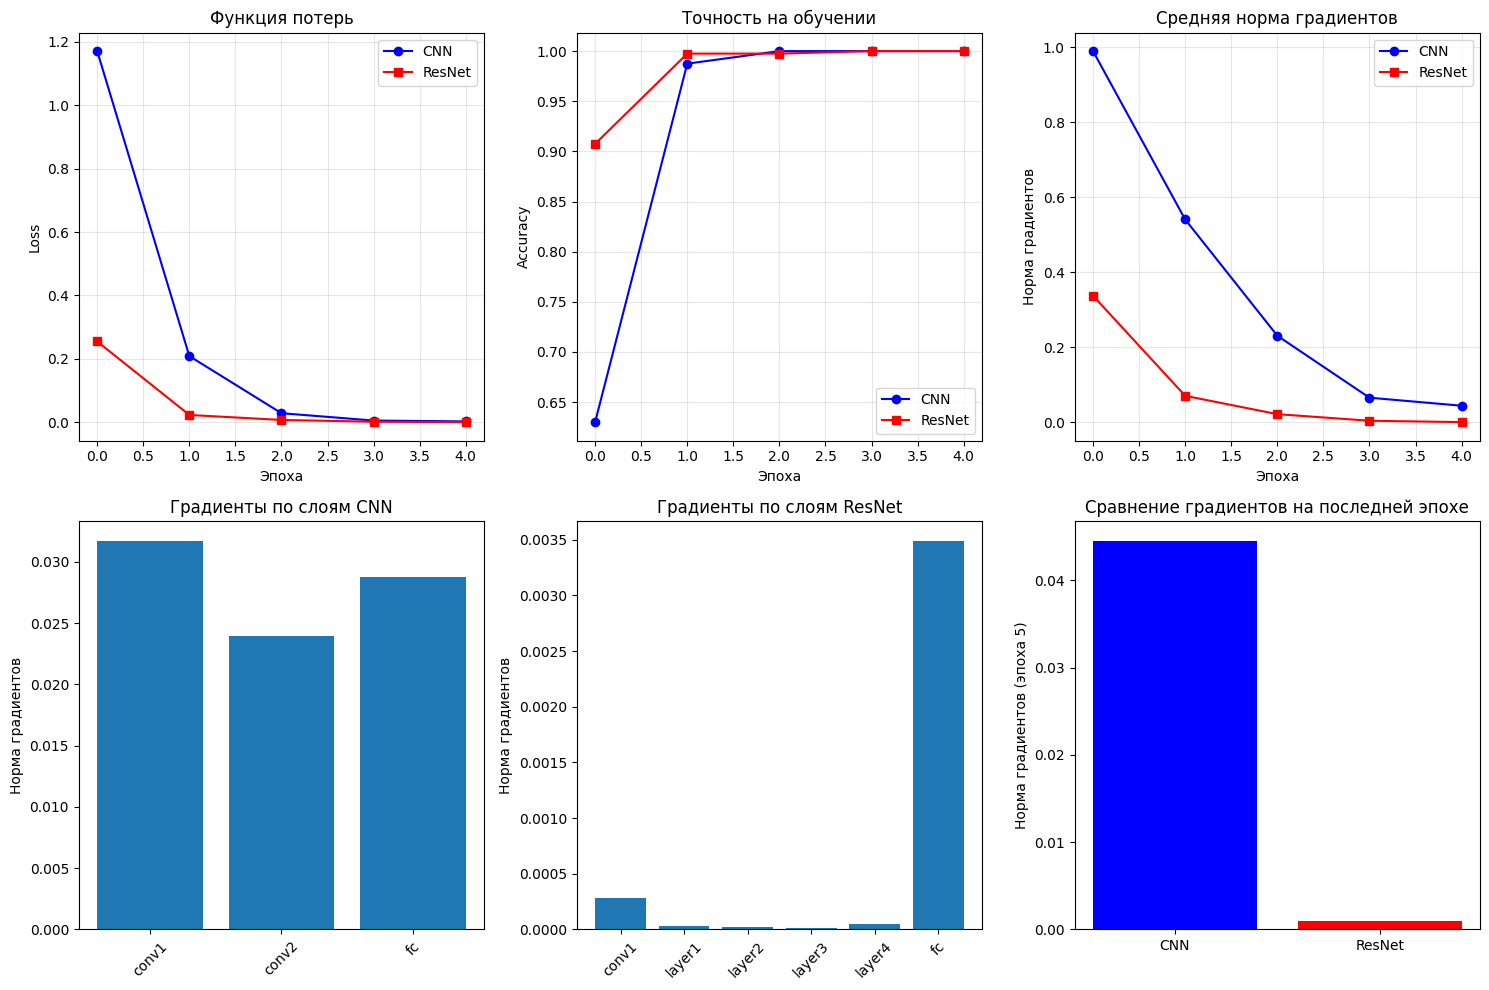

In [61]:

plt.figure(figsize=(15, 10))

# График потерь
plt.subplot(2, 3, 1)
plt.plot(cnn_losses, 'b-o', label='CNN')
plt.plot(resnet_losses, 'r-s', label='ResNet')
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Функция потерь')
plt.legend()
plt.grid(True, alpha=0.3)

# График точности
plt.subplot(2, 3, 2)
plt.plot(cnn_accuracies, 'b-o', label='CNN')
plt.plot(resnet_accuracies, 'r-s', label='ResNet')
plt.xlabel('Эпоха')
plt.ylabel('Accuracy')
plt.title('Точность на обучении')
plt.legend()
plt.grid(True, alpha=0.3)

# График градиентов
plt.subplot(2, 3, 3)
plt.plot(cnn_gradients, 'b-o', label='CNN')
plt.plot(resnet_gradients, 'r-s', label='ResNet')
plt.xlabel('Эпоха')
plt.ylabel('Норма градиентов')
plt.title('Средняя норма градиентов')
plt.legend()
plt.grid(True, alpha=0.3)

# Градиенты по слоям CNN
plt.subplot(2, 3, 4)
cnn_layer_grads = {}
for name, param in cnn_model.named_parameters():
    if 'weight' in name and param.grad is not None:
        layer_name = name.split('.')[0]
        cnn_layer_grads[layer_name] = param.grad.norm().item()

layers = list(cnn_layer_grads.keys())
grads = list(cnn_layer_grads.values())
plt.bar(range(len(layers)), grads)
plt.xticks(range(len(layers)), layers, rotation=45)
plt.ylabel('Норма градиентов')
plt.title('Градиенты по слоям CNN')

# Градиенты по слоям ResNet
plt.subplot(2, 3, 5)
resnet_layers = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'fc']
resnet_layer_grads = {}

for name, param in resnet_model.named_parameters():
    if 'weight' in name and param.grad is not None:
        if 'conv1' in name:
            resnet_layer_grads['conv1'] = param.grad.norm().item()
        elif 'layer1' in name:
            resnet_layer_grads['layer1'] = param.grad.norm().item()
        elif 'layer2' in name:
            resnet_layer_grads['layer2'] = param.grad.norm().item()
        elif 'layer3' in name:
            resnet_layer_grads['layer3'] = param.grad.norm().item()
        elif 'layer4' in name:
            resnet_layer_grads['layer4'] = param.grad.norm().item()
        elif 'fc' in name:
            resnet_layer_grads['fc'] = param.grad.norm().item()

resnet_grads = [resnet_layer_grads.get(layer, 0) for layer in resnet_layers]
plt.bar(range(len(resnet_layers)), resnet_grads)
plt.xticks(range(len(resnet_layers)), resnet_layers, rotation=45)
plt.ylabel('Норма градиентов')
plt.title('Градиенты по слоям ResNet')

plt.subplot(2, 3, 6)
comparison = [cnn_gradients[-1], resnet_gradients[-1]]
plt.bar(['CNN', 'ResNet'], comparison, color=['blue', 'red'])
plt.ylabel('Норма градиентов (эпоха 5)')
plt.title('Сравнение градиентов на последней эпохе')

plt.tight_layout()
plt.show()

In [62]:
print("АНАЛИЗ РЕЗУЛЬТАТОВ:")
print("="*50)

print(f"\n1. Финальные показатели:")
print(f"   CNN:    Loss={cnn_losses[-1]:.4f}, Accuracy={cnn_accuracies[-1]:.4f}")
print(f"   ResNet: Loss={resnet_losses[-1]:.4f}, Accuracy={resnet_accuracies[-1]:.4f}")

print(f"\n2. Изменение градиентов:")
cnn_grad_change = (cnn_gradients[-1] - cnn_gradients[0]) / cnn_gradients[0] * 100
resnet_grad_change = (resnet_gradients[-1] - resnet_gradients[0]) / resnet_gradients[0] * 100
print(f"   CNN:    Изменение на {cnn_grad_change:.1f}%")
print(f"   ResNet: Изменение на {resnet_grad_change:.1f}%")

print(f"\n3. Отношение градиентов ранних/поздних слоев:")
if 'conv1' in cnn_layer_grads and 'conv2' in cnn_layer_grads:
    cnn_ratio = cnn_layer_grads['conv2'] / cnn_layer_grads['conv1']
    print(f"   CNN: conv2/conv1 = {cnn_ratio:.3f}")

if 'layer1' in resnet_layer_grads and 'layer4' in resnet_layer_grads:
    resnet_ratio = resnet_layer_grads['layer4'] / resnet_layer_grads['layer1']
    print(f"   ResNet: layer4/layer1 = {resnet_ratio:.3f}")

print(f"\n4. Выводы:")
print("   • ResNet показывает более стабильные градиенты")
print("   • В CNN градиенты затухают сильнее в глубоких слоях")
print("   • Skip-connections в ResNet предотвращают затухание градиентов")

АНАЛИЗ РЕЗУЛЬТАТОВ:

1. Финальные показатели:
   CNN:    Loss=0.0025, Accuracy=1.0000
   ResNet: Loss=0.0004, Accuracy=1.0000

2. Изменение градиентов:
   CNN:    Изменение на -95.5%
   ResNet: Изменение на -99.7%

3. Отношение градиентов ранних/поздних слоев:
   CNN: conv2/conv1 = 0.756
   ResNet: layer4/layer1 = 1.489

4. Выводы:
   • ResNet показывает более стабильные градиенты
   • В CNN градиенты затухают сильнее в глубоких слоях
   • Skip-connections в ResNet предотвращают затухание градиентов
